In [37]:
# import libraries
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from google.colab import drive
import numpy as np
import os

In [2]:
# chech tensorflow version
tf.__version__

'2.8.0'

In [3]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [1]:
!cd '/content/gdrive/My Drive/Driver_distraction_monitoring'

In [ ]:
# Print number of images in  each class folder
dataset_path = '/content/gdrive/My Drive/Driver_distraction_monitoring/images/'
folder_names = os.listdir(dataset_path)
for folder_name in folder_names:
    print(f'{folder_name} ======>> {len(os.listdir(os.path.join(dataset_path,folder_name)))}')

In [7]:
# initialize some constants to use later
IMAGE_SIZE =  256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [8]:
# load dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory = "images",
    batch_size= BATCH_SIZE,
    image_size= (IMAGE_SIZE,IMAGE_SIZE),
    shuffle=True
)

Found 10002 files belonging to 10 classes.


In [9]:
# chek class names in data set
class_names = dataset.class_names
class_names

['drinking',
 'hair and makeup',
 'operating the radio',
 'reaching behind',
 'safe driving',
 'talking on the phone - left',
 'talking on the phone - right',
 'talking to passenger',
 'texting - left',
 'texting - right']

In [10]:
# lenght of data set
len(dataset)

313

#### 313 is the number of batches. Each batch contains 32 images. So 313 * 32 = 10016. But our images are 10002 which means that the last batch is not perfect. 

In [11]:
# lets take the 1st batch
for image, label in dataset.take(1):
    print(image.shape) # this will print batch size, shape and channels of the image
    print(label.numpy()) # this will prit class of each image in the batch

(32, 256, 256, 3)
[8 8 6 1 8 3 6 3 9 0 1 4 7 7 5 4 4 9 1 0 5 5 4 7 0 8 6 7 9 1 4 9]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


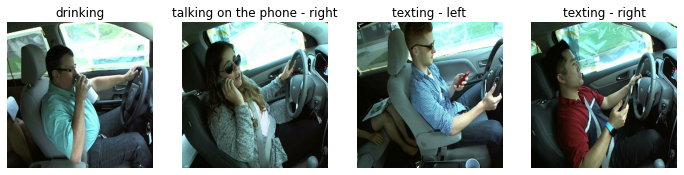

In [12]:
# show some images from data set
plt.figure(figsize = (12,12))
for image, label in dataset.take(2):
    for i in range(4):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.title(class_names[label[i]])
        plt.axis('off')

In [13]:
# split the data set into train, validation and test sets
# I'll take 80% of images as train, out of remaining 20% 10% will be validation set and remaining will be test set. 
len(dataset)

313

In [15]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [16]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [17]:
# optimize our dataset for training
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [18]:
# preproc. layers
scale_and_resize = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE ), # IMAGE_SIZE[0],IMAGE_SIZE[1]
    layers.experimental.preprocessing.Rescaling(1./255)
])

In [ ]:
# # data augmantation
# data_augmentation = tf.keras.Sequential([
#     layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
#     layers.experimental.preprocessing.RandomRotation(0.2),
# ])

In [19]:
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes = len(class_names)

model = models.Sequential([
    scale_and_resize,
    # data_augmentation,
    layers.Conv2D(32,(3,3), activation = 'relu', input_shape =input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes,activation = 'softmax'),
])

model.build(input_shape = input_shape)

In [20]:
# model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [21]:
# compile teh model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [22]:
# fit the model using our train and validation datasets with corresponding hyperparameters
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1
)

Epoch 1/50
250/250 [==============================] - 573s 94ms/step - loss: 1.7412 - accuracy: 0.3586 - val_loss: 0.7403 - val_accuracy: 0.7621
Epoch 2/50
250/250 [==============================] - 9s 37ms/step - loss: 0.5222 - accuracy: 0.8377 - val_loss: 0.3202 - val_accuracy: 0.9032
Epoch 3/50
250/250 [==============================] - 9s 37ms/step - loss: 0.2629 - accuracy: 0.9225 - val_loss: 0.1678 - val_accuracy: 0.9496
Epoch 4/50
250/250 [==============================] - 9s 37ms/step - loss: 0.1603 - accuracy: 0.9534 - val_loss: 0.1226 - val_accuracy: 0.9617
Epoch 5/50
250/250 [==============================] - 9s 37ms/step - loss: 0.1117 - accuracy: 0.9649 - val_loss: 0.1011 - val_accuracy: 0.9698
Epoch 6/50
250/250 [==============================] - 9s 37ms/step - loss: 0.1040 - accuracy: 0.9671 - val_loss: 0.1311 - val_accuracy: 0.9546
Epoch 7/50
250/250 [==============================] - 9s 37ms/step - loss: 0.0803 - accuracy: 0.9753 - val_loss: 0.1106 - val_accuracy: 0.96

In [24]:
# evaluate model accuracy
scores = model.evaluate(test_ds)

32/32 [==============================] - 14s 17ms/step - loss: 0.0265 - accuracy: 0.9941


In [25]:
history.params

{'epochs': 50, 'steps': 250, 'verbose': 1}

In [26]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [29]:
len(history.history['accuracy'])

50

In [30]:
# prepare values for plot
acc = history.history['accuracy']
loss = history.history['loss']

val_acc = history.history['val_accuracy'] 
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

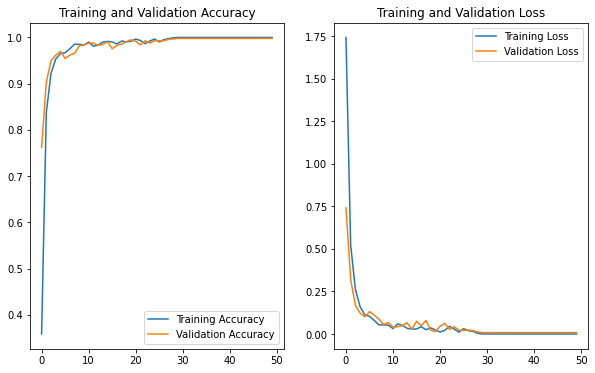

In [36]:
# plot train and validation accuracy as well as train and validation loss 
plt.figure(figsize = (10,6))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label = 'Training Loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')

First image to predict
Actual label: drinking
Predicted label drinking


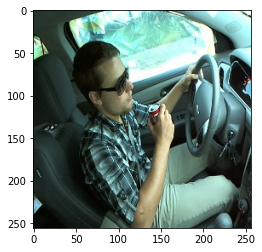

In [48]:
# Make prediction using test data. Show first predicted image
for imgs, labels in test_ds.take(1):
    
    first_image = imgs[0].numpy().astype('uint8')
    first_label = labels[0].numpy()

    print('First image to predict')
    plt.imshow(first_image)
    print('Actual label:', class_names[first_label])

    predicted_images = model.predict(imgs)
    print('Predicted label', class_names[np.argmax(predicted_images[0])])


In [49]:
# function for making predictions with given model 
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

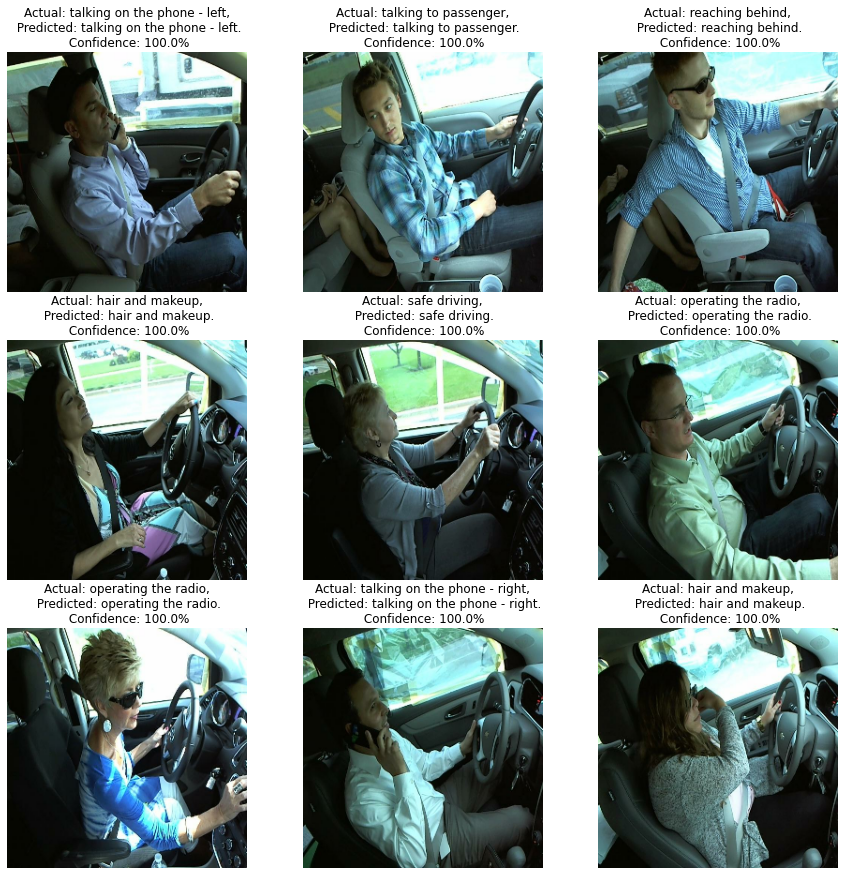

In [50]:
# Visualise some predictions
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [ ]:
# save the model
model.save("saved_models/model_2.h5")